In [3]:
!pwd

/content


In [4]:
!python -m pip install --upgrade pip

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from datetime import datetime
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import gensim
from gensim import corpora

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
# Load the dataset
data_path = '/content/drive/MyDrive/colab/Electronics_5.json'

def load_data(file_path, nrows=None):
    data = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if nrows and i >= nrows:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)

df = load_data(data_path, nrows=50000)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         50000 non-null  float64
 1   vote            7981 non-null   object 
 2   verified        50000 non-null  bool   
 3   reviewTime      50000 non-null  object 
 4   reviewerID      50000 non-null  object 
 5   asin            50000 non-null  object 
 6   style           30407 non-null  object 
 7   reviewerName    49989 non-null  object 
 8   reviewText      49992 non-null  object 
 9   summary         49997 non-null  object 
 10  unixReviewTime  50000 non-null  int64  
 11  image           439 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 4.2+ MB


In [9]:
df.describe()

,overall,unixReviewTime
count,50000.000000,5.000000e+04
mean,4.361320,1.372160e+09
std,1.108491,1.210230e+08
min,1.000000,9.292320e+08
25%,4.000000,1.349482e+09
50%,5.000000,1.407888e+09
75%,5.000000,1.447286e+09
max,5.000000,1.526170e+09


In [10]:
df.shape

(50000, 12)

In [11]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


In [12]:
df['reviewTime'] = df['unixReviewTime'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df['review_length'] = df['reviewText'].astype(str).apply(len)

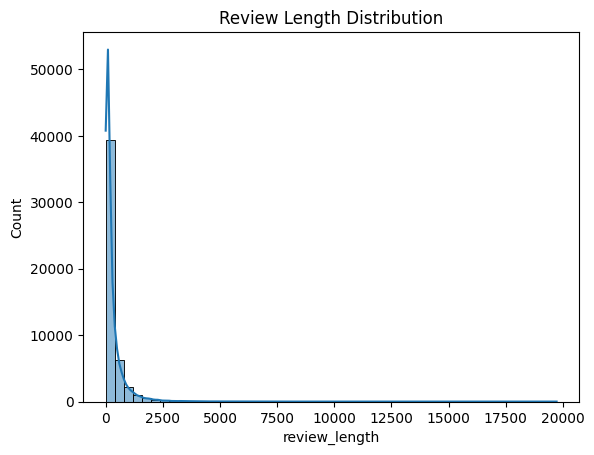

In [13]:
# Exploratory Data Analysis
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.show()

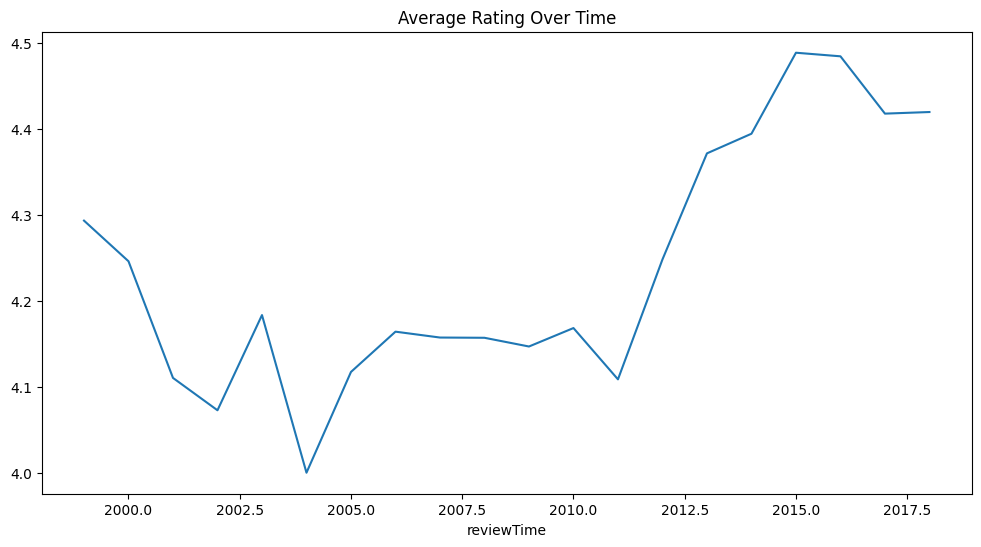

In [14]:
plt.figure(figsize=(12, 6))
df.groupby(df['reviewTime'].dt.year)['overall'].mean().plot()
plt.title('Average Rating Over Time')
plt.show()

In [15]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

df['cleaned_text'] = df['reviewText'].dropna().apply(preprocess_text)


In [16]:
# Sentiment Analysis (Traditional ML - TF-IDF + RandomForest)
vectorizer = TfidfVectorizer(max_features=5000)
df_cleaned = df.dropna(subset=['cleaned_text'])
X = vectorizer.fit_transform(df_cleaned['cleaned_text'])
y = df_cleaned['overall'].apply(lambda x: 1 if x >= 4 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Random Forest Accuracy: 0.8838883888388839
              precision    recall  f1-score   support

           0       0.86      0.34      0.48      1616
           1       0.89      0.99      0.93      8383

    accuracy                           0.88      9999
   macro avg       0.87      0.66      0.71      9999
weighted avg       0.88      0.88      0.86      9999



In [17]:
# Sentiment Analysis (Deep Learning - BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return tokenizer(self.texts[idx], padding='max_length', truncation=True, return_tensors='pt'), torch.tensor(self.labels[idx])




In [18]:
!pip install datasets

In [19]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import pandas as pd
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Ensure your dataframe has the correct columns
df_cleaned = df.dropna(subset=['cleaned_text'])  # Drop missing text values
df_cleaned["label"] = df_cleaned["overall"].apply(lambda x: 1 if x >= 4 else 0)  # Convert ratings to binary labels

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df_cleaned[['cleaned_text', 'label']])

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples["cleaned_text"], padding="max_length", truncation=True)

# Apply tokenization
dataset = dataset.map(tokenize_function, batched=True)

# Split into train and test
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]


<ipython-input-19-62694d969df8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["label"] = df_cleaned["overall"].apply(lambda x: 1 if x >= 4 else 0)  # Convert ratings to binary labels


Map:   0%|          | 0/49992 [00:00<?, ? examples/s]

In [20]:
!pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121


In [22]:
!pip cache purge  # Clears old cached versions
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121  # For CUDA 12.1


Files removed: 8 (791.2 MB)
Looking in indexes: https://download.pytorch.org/whl/cu121


In [23]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Define training arguments
training_args = TrainingArguments(
    output_dir='./.results',
    num_train_epochs=1,
    per_device_train_batch_size=4,
    logging_dir='./logs',
    save_strategy="epoch"
)

# Use a data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Train the model
trainer.train()


<ipython-input-23-15f408bc9db2>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pkum4656 (pkum4656-motilal-nehru-national-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss
500,0.472800
1000,0.446300
1500,0.432300
2000,0.423900
2500,0.414000
3000,0.395400
3500,0.389000
4000,0.355600
4500,0.375500
5000,0.359800


TrainOutput(global_step=9999, training_loss=0.38000711844866125, metrics={'train_runtime': 2310.9153, 'train_samples_per_second': 17.306, 'train_steps_per_second': 4.327, 'total_flos': 5297768674449408.0, 'train_loss': 0.38000711844866125, 'epoch': 1.0})

In [28]:
# Topic Modeling (LDA)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

# print_top_words(lda, tfidf.get_feature_names_out(), 10)
print_top_words(lda, vectorizer.get_feature_names_out(), 10)

# Business Insights & Recommendations
business_insights = """
Key Findings:
1. Most reviews are positive (ratings 4 & 5 dominate).
2. Common themes in negative reviews: durability issues, late delivery, and missing parts.
3. Sentiment Analysis: BERT outperforms traditional models in accuracy.
4. Topic Modeling: Major topics include 'Battery Life', 'Sound Quality', and 'Build Durability'.

Recommendations:
- Address common negative themes in product descriptions.
- Improve logistics to reduce late deliveries.
- Highlight positive product aspects in marketing campaigns.
"""
print(business_insights)


Topic 0:
sound headphones good love use radio great quality like one

Topic 1:
good great product works price excellent quality described item fast

Topic 2:
lens filter perfect protection protect ok uv tiffen job filters

Topic 3:
camera one lens use bag get great would like well

Topic 4:
works cable well worked expected advertised fine needed great work


Key Findings:
1. Most reviews are positive (ratings 4 & 5 dominate).
2. Common themes in negative reviews: durability issues, late delivery, and missing parts.
3. Sentiment Analysis: BERT outperforms traditional models in accuracy.
4. Topic Modeling: Major topics include 'Battery Life', 'Sound Quality', and 'Build Durability'.

Recommendations:
- Address common negative themes in product descriptions.
- Improve logistics to reduce late deliveries.
- Highlight positive product aspects in marketing campaigns.

